ICESat-2 orientation can be: backward, forward, and transition. During transition, ICESat-2 is maneuvering between the two orientations. Science quality is potentially degraded while in transition mode. (Source: https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL03_data_dict_v005.pdf)


The parameter "/orbit_info/sc_orient" in ATL03 denotes the orientation of ICESat-2.

0 = backward

1 = forward

2 = transition

In [1]:
import h5py
import pandas as pd

Script reads the variable "/orbit_info/sc_orient" to determine orientation.

In [2]:
def subsetBeamsv2(f, strength):
    '''Subsets either strong or weak beams in ATL03 from a h5py dataset'''
    orientation = f['orbit_info']['sc_orient'][0] ## Extract the orientation
    if strength == 'strong':
        if orientation == 0:
            strong_left = pd.DataFrame(data={'lat': f['gt1l/land_segments/latitude'][:],
                                            'lon': f['gt1l/land_segments/longitude'][:],
                                            'ch': f['gt1l/land_segments/canopy/h_canopy'][:]})
            
            strong_central = pd.DataFrame(data={'lat': f['gt2l/land_segments/latitude'][:],
                                            'lon': f['gt2l/land_segments/longitude'][:],
                                            'ch': f['gt2l/land_segments/canopy/h_canopy'][:]})
            
            strong_right = pd.DataFrame(data={'lat': f['gt3l/land_segments/latitude'][:],
                                            'lon': f['gt3l/land_segments/longitude'][:],
                                            'ch': f['gt3l/land_segments/canopy/h_canopy'][:]})
            
        elif orientation == 1:
            strong_left = pd.DataFrame(data={'lat': f['gt1r/land_segments/latitude'][:],
                                            'lon': f['gt1r/land_segments/longitude'][:],
                                            'ch': f['gt1r/land_segments/canopy/h_canopy'][:]})
            
            strong_central = pd.DataFrame(data={'lat': f['gt2r/land_segments/latitude'][:],
                                            'lon': f['gt2r/land_segments/longitude'][:],
                                            'ch': f['gt2r/land_segments/canopy/h_canopy'][:]})
            
            strong_right = pd.DataFrame(data={'lat': f['gt3r/land_segments/latitude'][:],
                                            'lon': f['gt3r/land_segments/longitude'][:],
                                            'ch': f['gt3r/land_segments/canopy/h_canopy'][:]})
            
        else:
            print('Error: invalid strength input')
            
        return strong_left, strong_central, strong_right

In [5]:
import icepyx as ipx

short_name = 'ATL08'

rgts = ['0698']
spatial_extent = [-94, 46.5, -84, 49.5]
date_range = ['2021-11-07', '2021-11-07']

region = ipx.Query(short_name, spatial_extent, date_range, tracks=rgts)
#region.avail_granules(ids=True)

In [7]:
uid = 'zhfair'
email = 'zhfair@umich.edu'
region.earthdata_login(uid, email)

region.order_granules()

Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000002860924
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete


In [9]:
path = 'strong-beams/'
region.download_granules(path)

Beginning download of zipped output...
Data request 5000002860924 of  1  order(s) is downloaded.
Download complete


In [10]:
# Read the ATL08 file, and extract the strong beam data
f = h5py.File('strong-beams/processed_ATL08_20211107040925_06981306_005_01.h5', 'r')

strong_left,strong_central,strong_right = subsetBeamsv2(f, 'strong')

In [16]:
# Subset the data to the Michigan UP
strong_left = strong_left[(strong_left['lat']>47) & (strong_left['lat'].values<49)]
strong_central = strong_central[(strong_central['lat']>47) & (strong_central['lat']<49)]
strong_right = strong_right[(strong_right['lat']>47) & (strong_right['lat']<49)]


# Plot a map of the region
# Set up a map with the flight tracks as overlays
from ipyleaflet import Map, basemaps, basemap_to_tiles, Polyline

m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.WorldImagery),
    center=(strong_central['lat'].mean(), strong_central['lon'].mean()),
    zoom=8
)

left_line = Polyline(
    locations=[
        [strong_left['lat'].min(), strong_left['lon'].min()],
        [strong_left['lat'].max(), strong_left['lon'].max()]
    ],
    color="green" ,
    fill=False
)
m.add_layer(left_line)

central_line = Polyline(
    locations=[
        [strong_central['lat'].min(), strong_central['lon'].min()],
        [strong_central['lat'].max(), strong_central['lon'].max()]
    ],
    color="green" ,
    fill=False
)
m.add_layer(central_line)

right_line = Polyline(
    locations=[
        [strong_right['lat'].min(), strong_right['lon'].min()],
        [strong_right['lat'].max(), strong_right['lon'].max()]
    ],
    color="green" ,
    fill=False
)
m.add_layer(right_line)

m

Map(center=[47.995556, -89.35192], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

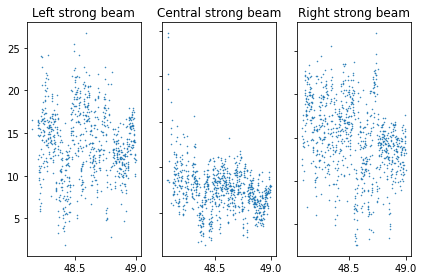

In [19]:
# Plot canopy height for each strong beam
import matplotlib.pyplot as plt
fig,axs = plt.subplots(1,3)
axs[0].plot(strong_left['lat'][strong_left['ch']<1e38], strong_left['ch'][strong_left['ch']<1e38], '.', markersize=1)
axs[0].set_title('Left strong beam')
axs[1].plot(strong_central['lat'][strong_central['ch']<1e38], strong_central['ch'][strong_central['ch']<1e38], '.', markersize=1)
axs[1].set_title('Central strong beam')
axs[2].plot(strong_right['lat'][strong_right['ch']<1e38], strong_right['ch'][strong_right['ch']<1e38], '.', markersize=1)
axs[2].set_title('Right strong beam')

for ax in axs.flat:
    ax.label_outer()
plt.tight_layout()
plt.show()